# Assignment 5, by Maksim Kaledin

This is a jupyter part of the report.

## Problem 7

First let us formulate the dual problem:

$$\begin{split}
& \max_\lambda \inf_x \left( 2x_1^2+2x_2^2-x_1x_2 +\lambda_1 (1-2x_1-3x_2)+\lambda_2(1-5x_1-4x_2)\right)\\
& s.t. \lambda \geq 0
\end{split}.$$

KKT conditions for the primal problem are

* (stationarity conditions) $\nabla_x L(x,\lambda)=0$
$$
\begin{split}
    &4x_1-x_2-2\lambda_1-5\lambda_2=0,\\
    &4x_2-x_1-3\lambda_1-4\lambda_2=0;
\end{split}
$$
* (feasibility conditions), these are constraints from initial primal problem;
* (complementary slackness conditions)
$$
\begin{split}
    &\lambda_1(1-2x_1-3x_2)=0,\\
    &\lambda_2(1-5x_1-4x_2)=0.
\end{split}
$$

In order to put the dual problem into CVX we also need to reformulate it to optimize a convex function:

$$\begin{split}
& \min_\lambda -\max_x \left[ -\left( 2x_1^2+2x_2^2-x_1x_2 +\lambda_1 (1-2x_1-3x_2)+\lambda_2(1-5x_1-4x_2)\right)\right]\\
& s.t. \lambda \geq 0
\end{split}.$$

## Problem 1

To handle censored data we can exploit the known information about lower bound: let us demand that predicted values for censored observations are bounded from below with $D$. The corresponding optimization problem is
$$
\begin{split}
&\min_{c^T} \sum_{i=1}^{M} (c^Tx_i-y_i)^2,\\
&s.t. \quad c^Tx_i>D \quad \text{for $i>M$},
\end{split}
$$
where $M$ is amount of known $y_i$, $x_i$ are input data vectors. 

In [1]:
import numpy as np #necessary imports
import cvxpy as cv
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Data generation
n=50
M=25
K=100

np.random.seed(1)
c_true = np.random.randn(n)
X=np.random.randn(n,K)
y=np.dot(X.T, c_true)+0.1*np.sqrt(n)*np.random.randn(K)
print(c_true.shape)

#Reorder
sort_ind=np.argsort(y)
X=X[:, sort_ind]
y=y[sort_ind[:(M+1)]]
D=(y[M-1]+y[M])/2
y=y[:M]

(50,)


In [113]:
c_hat = cv.Variable(X.shape[0])

censSq_constr = [X[:,M:].T*c_hat >= D*np.ones((K-M,1))]
censSq_problem = cv.Problem(cv.Minimize(cv.sum_squares(X[:,:M].T*c_hat-y)),censSq_constr)

censSq_problem.solve()

print(censSq_problem.status)
print(censSq_problem.value)
print(c_hat.value)

optimal
1.0950050558895646e-10
[[ 0.76795189]
 [-0.87085575]
 [-0.40230562]
 [-0.92266419]
 [ 0.45592196]
 [-2.86082015]
 [ 1.70548005]
 [-0.94748275]
 [ 0.36187106]
 [ 0.22206301]
 [ 1.01676167]
 [-2.35450454]
 [-0.60568695]
 [-0.42925672]
 [ 1.79542858]
 [-0.95766552]
 [-0.05072968]
 [-1.03390661]
 [-0.2543782 ]
 [-0.01100263]
 [-1.66266204]
 [ 0.42264016]
 [ 0.60047498]
 [ 0.1675193 ]
 [ 0.62748778]
 [-1.69731848]
 [-0.78573313]
 [-0.73099875]
 [-0.68651668]
 [ 0.66370163]
 [-0.34845174]
 [-0.4249284 ]
 [-0.29632187]
 [-0.32545624]
 [-1.50955969]
 [ 0.30865187]
 [-1.35152484]
 [-0.57152832]
 [ 0.97354245]
 [ 0.44884914]
 [-0.42551117]
 [-1.87251964]
 [-0.39856967]
 [ 1.61011641]
 [ 1.13408216]
 [ 0.32587678]
 [-0.11548495]
 [ 1.32700049]
 [-0.34208876]
 [ 1.32834106]]


We calculated some coefficients, let us check the relative errors and compare it with usual least squares. Compute $c_{ls}$ first.

In [114]:
c_hat_ls = cv.Variable(X.shape[0])

#no constraints
censSq_ls_problem = cv.Problem(cv.Minimize(cv.sum_squares(X[:,:M].T*c_hat_ls-y)),[])

censSq_ls_problem.solve()

print(censSq_ls_problem.status)
print(censSq_ls_problem.value)
print(c_hat_ls.value)

optimal
-1.4100574345150884e-09
[[ 0.90143316]
 [ 0.56913463]
 [-0.0765625 ]
 [-1.57977159]
 [ 0.6634653 ]
 [-2.18344329]
 [ 0.40528648]
 [-0.55814067]
 [ 0.46279896]
 [ 0.4079013 ]
 [ 0.84562688]
 [-0.83582101]
 [-0.61593981]
 [-0.23222525]
 [ 0.94994997]
 [ 0.35055971]
 [-0.28562874]
 [-1.3043138 ]
 [ 0.25738804]
 [ 1.13690832]
 [-1.0701735 ]
 [ 0.85000453]
 [ 0.66540539]
 [ 0.88132219]
 [ 0.84403993]
 [-1.23552217]
 [-0.69549918]
 [-0.0543861 ]
 [ 0.42915103]
 [ 0.41166014]
 [-1.11664903]
 [-0.35735008]
 [-0.770775  ]
 [-0.50821114]
 [-0.71460133]
 [ 0.57814047]
 [-0.52527329]
 [-0.09066512]
 [ 1.09980212]
 [ 0.73169426]
 [-0.15164279]
 [-2.47997227]
 [ 0.07078504]
 [ 1.12453812]
 [-0.69555995]
 [-0.41661622]
 [ 0.02817175]
 [ 1.27340896]
 [-0.62115046]
 [ 0.7308135 ]]


Check relative errors.

In [115]:
print(np.linalg.norm(c_hat.value-c_true,2)/np.linalg.norm(c_true,2))
print(np.linalg.norm(c_hat_ls.value-c_true,2)/np.linalg.norm(c_true,2))

7.85783995198
7.07973929379


## Problem 2

Denote by $t_i$ the travel time on a segment $i$, $i\in{0,..,n}$ ($t$ is a vector of $t_i$), let $n+1$ be a number of waypoints enumareted from $0$, $d_i$ be the length of $i$-th segment, $s_{min}^i,s_{max}^i$ and $T^{i}_{min},T^i_{max}$ be the speed and schedule constraints described in the problem. The corresponding optimization problem is

$$
\begin{split}
&\min_{t} \sum_{i=0}^n \Phi\left( \frac{d_i}{t_i}\right),\\
& s.t. \quad \forall i \quad {t_i} \geq \frac{d_i}{s_{max}^i},~ {t_i} \leq \frac{d_i}{s_{min}^i},\\
& \quad \forall i \sum_{j=0}^i t_j \leq T_{max}^i, ~ \sum_{j=0}^i t_j \geq T_{min}^i,\\
& \quad \forall i ~ t_i \geq 0.
\end{split}
$$

We need to properly feed it to CVXPY and obtain solution.

In [10]:
import numpy as np #necessary imports
import cvxpy as cv
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio 

In [11]:


mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0,0]
b = mat_contents['b'][0,0]
c = mat_contents['c'][0,0]
d = mat_contents['d'].squeeze()
n = mat_contents['n'][0,0]
s_min = mat_contents['smin'].squeeze()
s_max = mat_contents['smax'].squeeze()
tau_min = mat_contents['tau_min'].squeeze()
tau_max = mat_contents['tau_max'].squeeze()
print(tau_min.shape)
print(n)
print(d.shape)

(100,)
100
(100,)


In [92]:
ts = cv.Variable(tau_min.shape[0],1)


veh_obj = cv.Minimize(a*cv.sum_entries(cv.mul_elemwise(d**2,cv.inv_pos(ts)))+b*np.sum(d)+cv.sum_entries(c*ts))
A=np.ones((n,n))
rows,cols = np.indices(A.shape)
A[cols-rows>0]=0
veh_constr = [ts<=d/s_min, ts >= d/s_max, A*ts <= tau_max, A*ts >= tau_min ]

veh_problem = cv.Problem(veh_obj,veh_constr)

veh_problem.solve()

print(veh_problem.status)
print(veh_problem.value)

optimal
2617.8251935174217


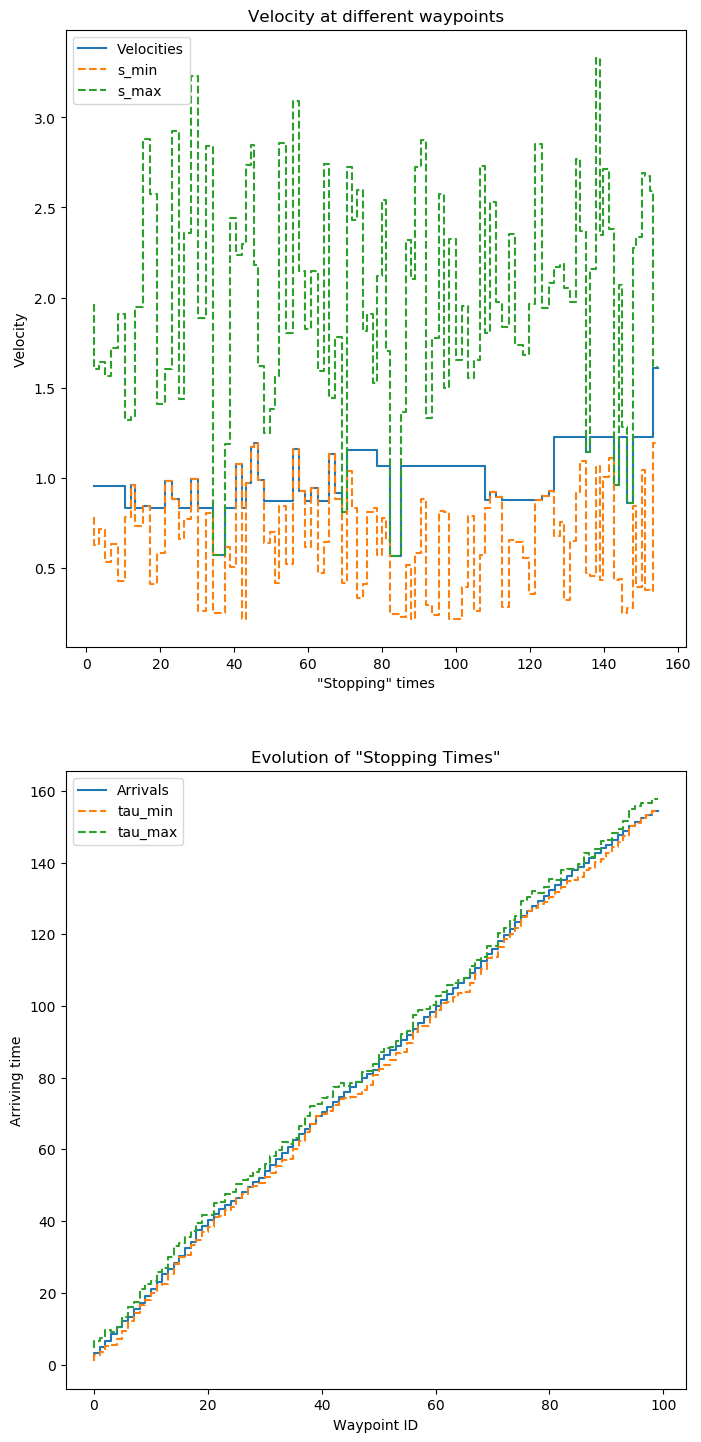

In [112]:

f, (ax1,ax2)= plt.subplots(2,1,figsize=(8,18))

times = ts.value
times=times.reshape(1,n)

timesd=(d/times).reshape(n,1)
times=times.reshape(n,1)


plt_velocities, = ax1.step(A.dot(times),timesd)
plt_smin, = ax1.plot(A.dot(times),s_min,linestyle='--',linewidth=1.5, drawstyle='steps')
plt_smax, = ax1.plot(A.dot(times),s_max,linestyle='--',linewidth=1.5, drawstyle='steps')

ax1.set_title('Velocity at different waypoints')
ax1.set_xlabel('"Stopping" times')
ax1.set_ylabel('Velocity')
ax1.legend([plt_velocities,plt_smin,plt_smax],["Velocities","s_min","s_max"])


plt_arrivings, = ax2.step(np.arange(n),A.dot(times))
plt_taumin, = ax2.plot(np.arange(n),tau_min, linestyle='--',linewidth=1.5, drawstyle='steps')
plt_taumax, = ax2.plot(np.arange(n),tau_max, linestyle='--',linewidth=1.5, drawstyle='steps')
ax2.set_title('Evolution of "Stopping Times"')
ax2.set_xlabel('Waypoint ID')
ax2.set_ylabel('Arriving time')
ax2.legend([plt_arrivings,plt_taumin,plt_taumax],["Arrivals","tau_min","tau_max"])